<img src = "https://github.com/VeryFatBoy/notebooks/blob/main/common/images/img_github_singlestore-jupyter_featured_2.png?raw=true">

<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Using Approximate Nearest Neighbor (ANN) Search with SingleStoreDB</h1>
    </div>
</div>

In [4]:
!pip cache purge

Files removed: 612


In [5]:
!pip install matplotlib --quiet
!pip install tensorflow --quiet

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import struct

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

from tensorflow import keras
from keras.datasets import fashion_mnist

2024-09-25 20:53:10.664199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 20:53:10.796542: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 20:53:10.837605: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [10]:
print("train_images: " + str(train_images.shape))
print("train_labels: " + str(train_labels.shape))
print("test_images:  " + str(test_images.shape))
print("test_labels:  " + str(test_labels.shape))

train_images: (60000, 28, 28)
train_labels: (60000,)
test_images:  (10000, 28, 28)
test_labels:  (10000,)


In [11]:
print(train_images[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

In [12]:
print(train_labels[0])

9


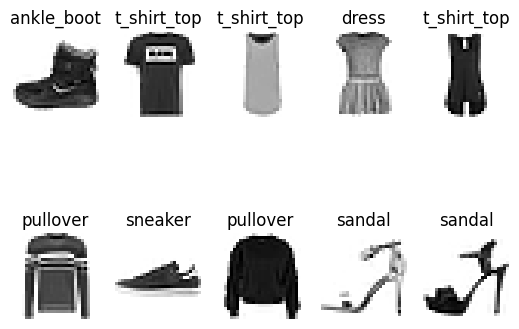

In [15]:
classes = [
    "t_shirt_top",
    "trouser",
    "pullover",
    "dress",
    "coat",
    "sandal",
    "shirt",
    "sneaker",
    "bag",
    "ankle_boot"
]

num_classes = len(classes)

for i in range(num_classes):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(
        np.column_stack(train_images[i].reshape(1, 28, 28)),
        cmap = plt.cm.binary
    )
    plt.axis("off")
    ax.set_title(classes[train_labels[i]])

In [16]:
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

In [17]:
print("train_images: " + str(train_images.shape))
print("test_images:  " + str(test_images.shape))

train_images: (60000, 784)
test_images:  (10000, 784)


In [18]:
train_data_df = pd.DataFrame([
    (i,
     image.astype(int).tolist(),
     classes[int(label)],
    ) for i, (image, label) in enumerate(zip(train_images, train_labels))
], columns = ["idx", "img", "label"])

test_data_df = pd.DataFrame([
    (i,
     image.astype(int).tolist(),
     classes[int(label)],
    ) for i, (image, label) in enumerate(zip(test_images, test_labels))
], columns = ["idx", "img", "label"])

In [19]:
train_data_df.head()

,idx,img,label
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ankle_boot
1,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 41, 188, 103, 5...",t_shirt_top
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 118, 24, 0, 0,...",t_shirt_top
3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 33, 96, 175, 156, 64,...",dress
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",t_shirt_top


In [20]:
test_data_df.head()

,idx,img,label
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ankle_boot
1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 67, 0, 0, 0...",pullover
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 67, 177, 129, 1...",trouser
3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 123, 108, 99, ...",trouser
4,4,"[0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 57, 67, 73, ...",shirt


In [21]:
def data_to_binary(data: list[float]):
    format_string = "f" * len(data)
    return struct.pack(format_string, *data)

train_data_df["vector"] = train_data_df["img"].apply(data_to_binary)
test_data_df["vector"] = test_data_df["img"].apply(data_to_binary)

In [22]:
train_data_df.head()

,idx,img,label,vector
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ankle_boot,"b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00..."
1,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 41, 188, 103, 5...",t_shirt_top,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 118, 24, 0, 0,...",t_shirt_top,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 33, 96, 175, 156, 64,...",dress,"b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00..."
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",t_shirt_top,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...


In [23]:
test_data_df.head()

,idx,img,label,vector
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ankle_boot,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 67, 0, 0, 0...",pullover,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 67, 177, 129, 1...",trouser,"b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00..."
3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 123, 108, 99, ...",trouser,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
4,4,"[0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 57, 67, 73, ...",shirt,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...


In [24]:
train_data_df.drop("img", axis = 1, inplace = True)
test_data_df.drop("img", axis = 1, inplace = True)

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p>Select the database from the drop-down menu at the top of this notebook. It updates the <b>connection_url</b> which is used by SQLAlchemy to make connections to the selected database.</p>
    </div>
</div>

In [25]:
from sqlalchemy import *

db_connection = create_engine(connection_url)

In [26]:
train_data_df.to_sql(
    "train_data_blob",
    con = db_connection,
    if_exists = "append",
    index = False,
    chunksize = 1000
)

60000

In [31]:
test_data_df.to_sql(
    "test_data_blob",
    con = db_connection,
    if_exists = "append",
    index = False,
    chunksize = 1000
)

10000

# License
The MIT License (MIT) Copyright © [2017] Zalando SE, https://tech.zalando.com

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.